In [64]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
import numpy as np
from src.models.cifar10.resnet import ResNet18
from src.models.cifar10.googlenet import GoogLeNet
from src.models.cifar10.mobilenet import MobileNet
from src.models.cifar10.mobilenetv2 import MobileNetV2
from src.models.cifar10.densenet import DenseNet121 

In [65]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [66]:
model = MobileNetV2().to(device)

model.load_state_dict(torch.load('./pretrained/MobileNetV2_cifar10_gap_model.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [67]:
model.eval()

MobileNetV2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
     

In [48]:
def gen_feature_map(feature_, idx):
    length = len(feature_)
    
    size = np.sqrt(length)
    
    r, c = int(size), int(size)

    fig, axs = plt.subplots(r, c, figsize=(10,10))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(feature_[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("feature_%d.png" % idx)
    plt.show()

feature_blobs = []

def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())

print(model._modules)

model._modules.get('bn').register_forward_hook(hook_feature)

params = list(model.parameters())

class_weights = np.squeeze(params[-2].cpu().data.numpy())

OrderedDict([('conv1', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)), ('dense1', Sequential(
  (0): Bottleneck(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (1): Bottleneck(
    (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (2): Bottleneck(
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Con

)), ('bn', BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('linear', Linear(in_features=1024, out_features=10, bias=True))])


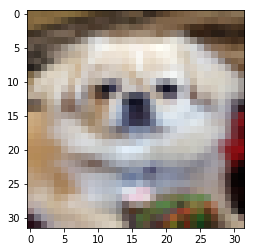

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = './cifar10/test/dog/0101.png'

img = Image.open(img_path)

plt.imshow(img)

In [50]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 32,32)

tensor_img = Variable(tensor_img, requires_grad=True)

output = model(tensor_img)

In [51]:
from torch.nn import functional as F

h_x = F.softmax(output, dim=1).data.squeeze()

In [52]:
print(h_x.sort(0, True))

pred = h_x.argmax(0).item()
print(pred)
print(class_name[pred])

torch.return_types.sort(
values=tensor([1.0000e+00, 3.1919e-12, 2.9338e-13, 2.4944e-15, 1.8628e-15, 1.2779e-16,
        2.5753e-17, 1.4065e-18, 1.6755e-19, 7.9140e-20], device='cuda:0'),
indices=tensor([5, 8, 1, 9, 6, 2, 7, 0, 3, 4], device='cuda:0'))
5
dog


In [53]:
print(len(feature_blobs))

1


In [54]:
for feature in feature_blobs:
    print(feature.shape)

(1, 1024, 4, 4)


In [55]:
final_conv = feature_blobs[0][0]

cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i, w in enumerate(class_weights[pred]):
    cam += w*final_conv[i,:,:]

In [56]:
def scaling(img):
    img = img - np.min(img)
    img = img / np.max(img)
    
    return img

In [57]:
scaled_cam = scaling(cam)
scaled_cam

array([[0.01370068, 0.3304489 , 0.427757  , 0.20665655],
       [0.51712435, 1.        , 0.86845475, 0.5630152 ],
       [0.5058408 , 0.864753  , 0.73002416, 0.47396833],
       [0.2900799 , 0.15195668, 0.        , 0.25349376]], dtype=float32)

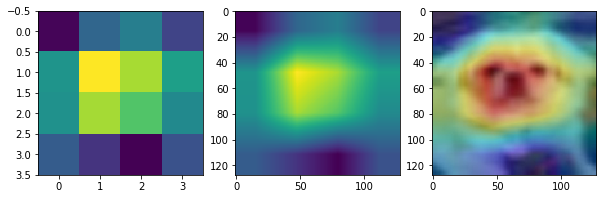

In [58]:
import cv2

fig, axs = plt.subplots(1, 3, figsize=(10,10))

axs[0].imshow(scaled_cam)

resized_cam = cv2.resize(scaled_cam, (128, 128))

axs[1].imshow(resized_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * resized_cam), cv2.COLORMAP_JET)

img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))
heatimg = heatmap*0.4 + img*0.5
cv2.imwrite('./cam.jpg', heatimg)

cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

axs[2].imshow(cam_img)

Before: float32
After: uint8
number of contours: 1


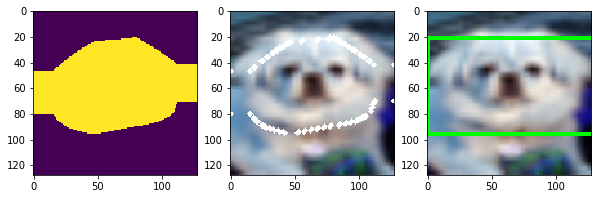

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))

threshold = 0.5

_, thresholded_heatmap = cv2.threshold(resized_cam, threshold * resized_cam.max(), 1, cv2.THRESH_BINARY)

axs[0].imshow(thresholded_heatmap)

print('Before:',thresholded_heatmap.dtype)
thresholded_heatmap = cv2.convertScaleAbs(thresholded_heatmap)
print('After:',thresholded_heatmap.dtype)

contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number of contours:',len(contours))

contour_areas = []   
for i, c in enumerate(contours):
    contour_areas.append(cv2.contourArea(c))
    
# contour 면적이 큰 순서대로 정렬
sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)

# # contour 면적이 큰 contours 선택
biggest_contour= sorted_contours[0][1]

# -1 : represent entire contours
# (255, 255, 255): color
# 3 : thinkness 
contour_image = cv2.drawContours(img.copy(), biggest_contour, -1, (255, 255, 255), 3)
axs[1].imshow(contour_image)

x,y,w,h = cv2.boundingRect(biggest_contour)
box_image = cv2.rectangle(img.copy(), (x,y), (x+w, y+h), (0, 255,0), 2)

axs[2].imshow(box_image)

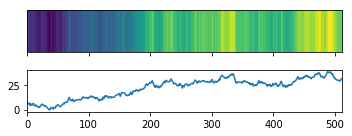

In [9]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
plt.rcParams["figure.figsize"] = 5,2

x = np.arange(512)
y = np.cumsum(np.random.randn(512))+6

fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y[np.newaxis,:], aspect="auto", extent=extent)
ax.set_yticks([])
ax.set_xlim(extent[0], extent[1])

ax2.plot(x,y)

plt.tight_layout()
plt.show()

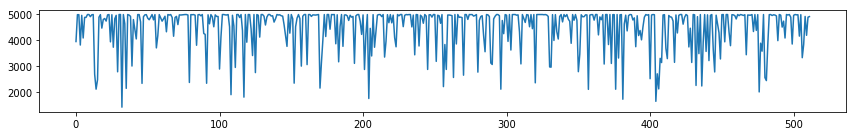

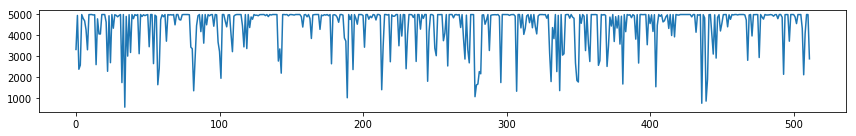

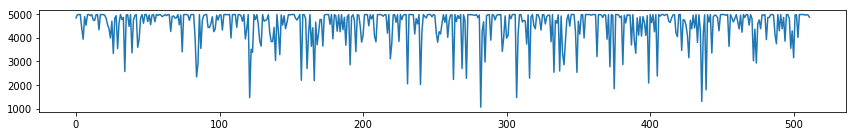

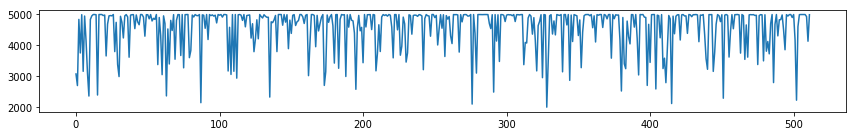

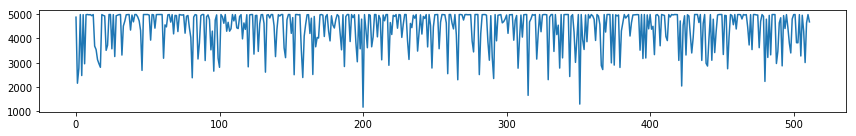

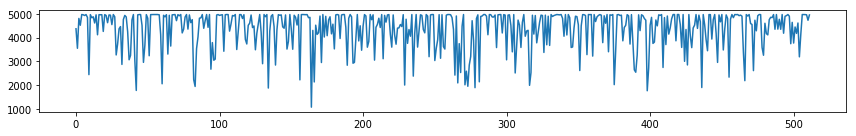

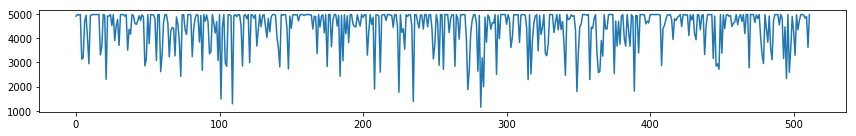

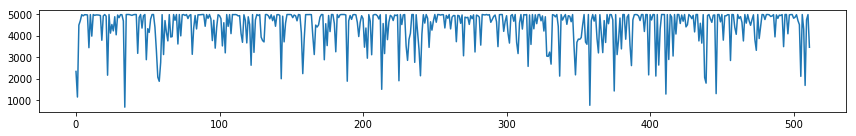

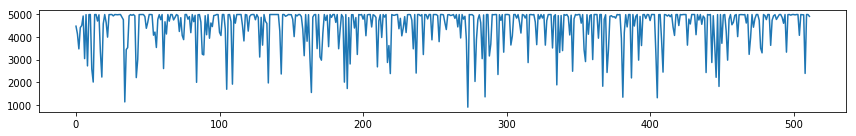

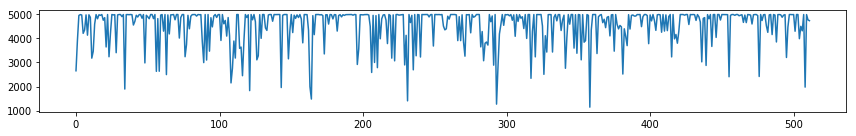

In [197]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for c in class_name:
    with open(c + '_train.pickle', 'rb') as f:
        data = pickle.load(f)
    
    #mask = data < 850
    
    #data[mask] = 0
    
    plt.rcParams["figure.figsize"] = 12,2

    x = np.arange(512)
    y = data

    fig, ax2 = plt.subplots(nrows=1, sharex=True)

    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    #ax.imshow(y[np.newaxis,:], aspect="auto", extent=extent)
    ax.set_yticks([])
    ax.set_xlim(extent[0], extent[1])

    ax2.plot(x,y)

    plt.tight_layout()
    plt.show()

In [69]:
import pickle

with open('./pickle/airplane_train.pickle', 'rb') as f:
    data = pickle.load(f)

In [71]:
data.shape

(512,)